In [ ]:
!pip install backtesting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 4.4 MB/s eta 0:00:00


In [14]:
#drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
cd "/content/drive/MyDrive/Colab Notebooks/TicTocStock/data"

/content/drive/MyDrive/Colab Notebooks/TicTocStock/data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy
from backtesting.lib import crossover

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# CSV 로드
signals = pd.read_csv("All_TA_signals.csv", parse_dates=["Date"])
prices = pd.read_csv("TA_data_30.csv", parse_dates=["Date"])

# 병합
df = (
    signals
    .merge(prices[["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]],
           on=["Date", "Ticker"], how="left")
    .dropna(subset=["Open", "High", "Low", "Close", "Volume"])
    .sort_values(["Ticker", "Date"])
)

# 2024년 테스트 구간만 추출
test = df.copy()

In [ ]:
# 전략 클래스 정의

class RawSignalStrategy(Strategy):
    signal_col = None

    def init(self):
        self.signal = self.data.df[self.signal_col]
        self.last_date = self.data.df.index[-1]  # 백테스트 종료 날짜

    def next(self):
        # s = self.signal.iloc[-1]
        # current_date = self.data.df.index[self.data.index]
        try:
            s = self.signal[-1]
        except IndexError:
             return # 오류 발생 시 해당 step 건너뛰기
        current_date = self.data.index[-1]

        # 1. 매수 조건
        if s == -1 and not self.position:
            self.buy()
        # 2. 매도 조건
        elif s == 1 and self.position:
            self.position.close()
        # 3. 종료일에는 무조건 포지션 정리
        elif current_date == self.last_date and self.position:
            self.position.close()

In [ ]:
# 수익률, MDD, Sharpe, Fitness 계산 함수
initial_cash = 100_000 # 초기 자본

def compute_metrics(stats, cash):
    r = stats['Return [%]'] / 100
    mdd = abs(stats['Max. Drawdown [%]'] / 100)
    sharpe = stats['Sharpe Ratio']
    profit = r * cash  # 실제 이익 계산
    fitness = 0.8 * (1 / (r + 1e-8)) + 0.2 * mdd if r > 0 else np.inf
    return r, profit, mdd, sharpe, fitness

signal_cols = [c for c in df.columns if c.endswith("_signal")] # 시그널 컬럼 목록
tickers = test["Ticker"].unique()[:10]
results = []

for feat in signal_cols:
    for ticker in tickers:
        df_t = test[test["Ticker"] == ticker].copy()
        if df_t.empty: continue

        # 시그널 컬럼을 숫자로 강제 변환 후 NaN은 0으로
        df_t[feat] = pd.to_numeric(df_t[feat], errors='coerce').fillna(0)

        bt_df = df_t.set_index("Date")[["Open", "High", "Low", "Close", "Volume", feat]]

        if not bt_df.index.is_monotonic_increasing:
             print(f"⚠️ 데이터 정렬 오류 | Ticker: {ticker}, Signal: {feat} | 인덱스 재정렬 시도")
             bt_df = bt_df.sort_index()

        RawSignalStrategy.signal_col = feat
        try:
            bt = Backtest(
                bt_df,
                RawSignalStrategy,
                cash=100_000,
                commission=0.001,
                trade_on_close=True,
                exclusive_orders=True
            )
            stats = bt.run()

            ret, profit, mdd, sharpe, fitness = compute_metrics(stats, initial_cash)
            results.append({
                "Ticker": ticker,
                "Signal": feat,
                "Return": round(ret, 4),
                "Profit ($)": round(profit, 2),
                "MDD": round(mdd, 4),
                "Sharpe": round(sharpe, 4),
                "Fitness": round(fitness, 4)
            })
        except Exception as e:
          print(f"❌ 예외 발생 | Ticker: {ticker}, Signal: {feat} | Error: {str(e)}")
          continue

    Ticker       Signal  Return  Profit ($)     MDD  Sharpe  Fitness
116   ORLY   CCI_signal  8.1328   813281.28  0.4200  0.6906   0.1824
176   ORLY    BB_signal  8.1328   813281.28  0.4200  0.6906   0.1824
231     HD    AD_signal  3.7479   374791.43  0.3840  0.5483   0.2902
161     HD  ATRr_signal  3.7479   374791.43  0.3840  0.5483   0.2902
261     HD  VWAP_signal  3.7479   374791.43  0.3840  0.5483   0.2902
113    MAR   CCI_signal  4.7550   475498.09  0.6141  0.4565   0.2911
263    MAR  VWAP_signal  4.7550   475498.09  0.6141  0.4565   0.2911
233    MAR    AD_signal  4.7550   475498.09  0.6141  0.4565   0.2911
222    LOW   MFI_signal  4.0337   403371.33  0.4862  0.4815   0.2956
162    LOW  ATRr_signal  4.0337   403371.33  0.4862  0.4815   0.2956
202    LOW  NATR_signal  4.0337   403371.33  0.4862  0.4815   0.2956
242    LOW   EFI_signal  4.0337   403371.33  0.4862  0.4815   0.2956
262    LOW  VWAP_signal  4.0337   403371.33  0.4862  0.4815   0.2956
282    LOW   PGO_signal  4.0337   

<ipython-input-31-3dfbcd02e258>:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


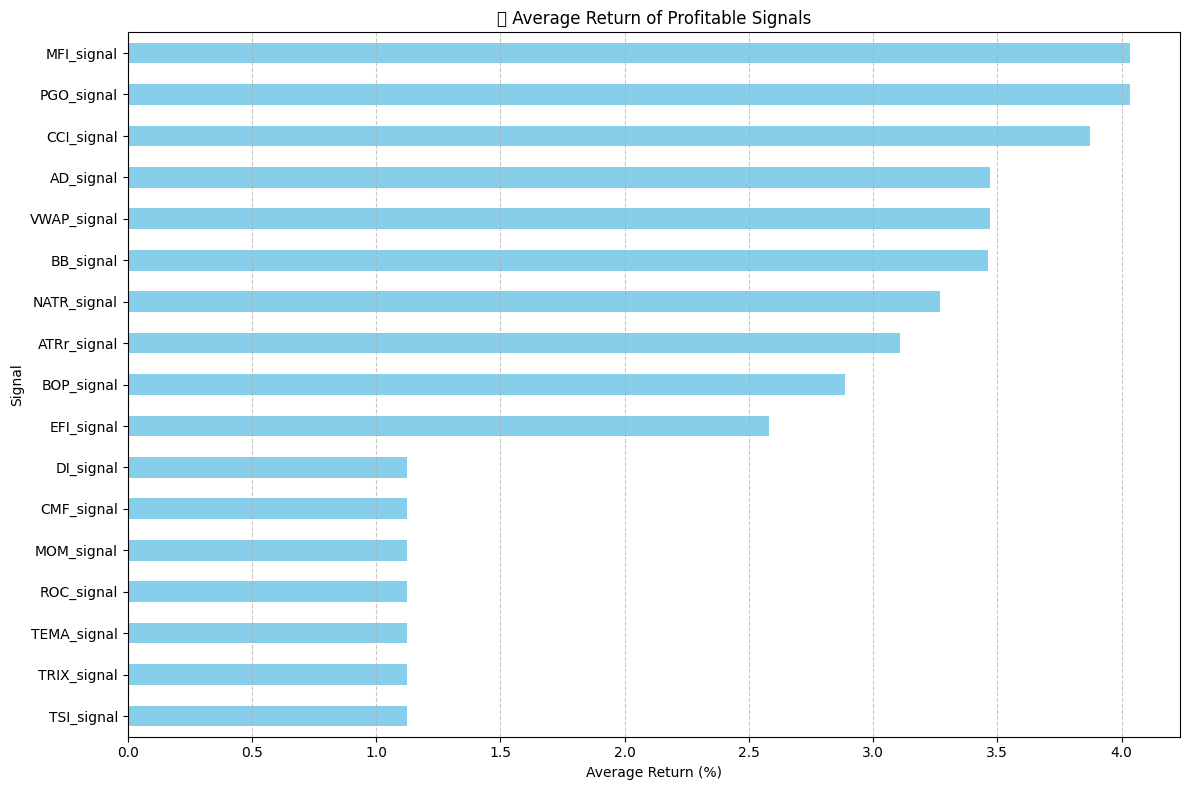

In [ ]:
# 결과 출력
result_df = pd.DataFrame(results)
result_df.sort_values(by="Fitness", inplace=True)
print(result_df.head(20))  # 상위 20개 출력

# CSV로 저장
result_df.to_csv("backtest_results.csv", index=False)
print("✅ backtest_results.csv 저장 완료")

# 3. 수익률이 0보다 큰 시그널만 필터링
profitable_df = result_df[result_df["Return"] > 0]

# 4. 지표별 평균 수익률 계산
avg_returns = profitable_df.groupby("Signal")["Return"].mean().sort_values(ascending=False)

# 5. 시각화
plt.figure(figsize=(12, 8))
avg_returns.plot(kind="barh", color="skyblue")
plt.title("Average Return of Profitable Signals")
plt.xlabel("Average Return (%)")
plt.ylabel("Signal")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().invert_yaxis()  # 수익률 높은 순 정렬
plt.tight_layout()
plt.show()

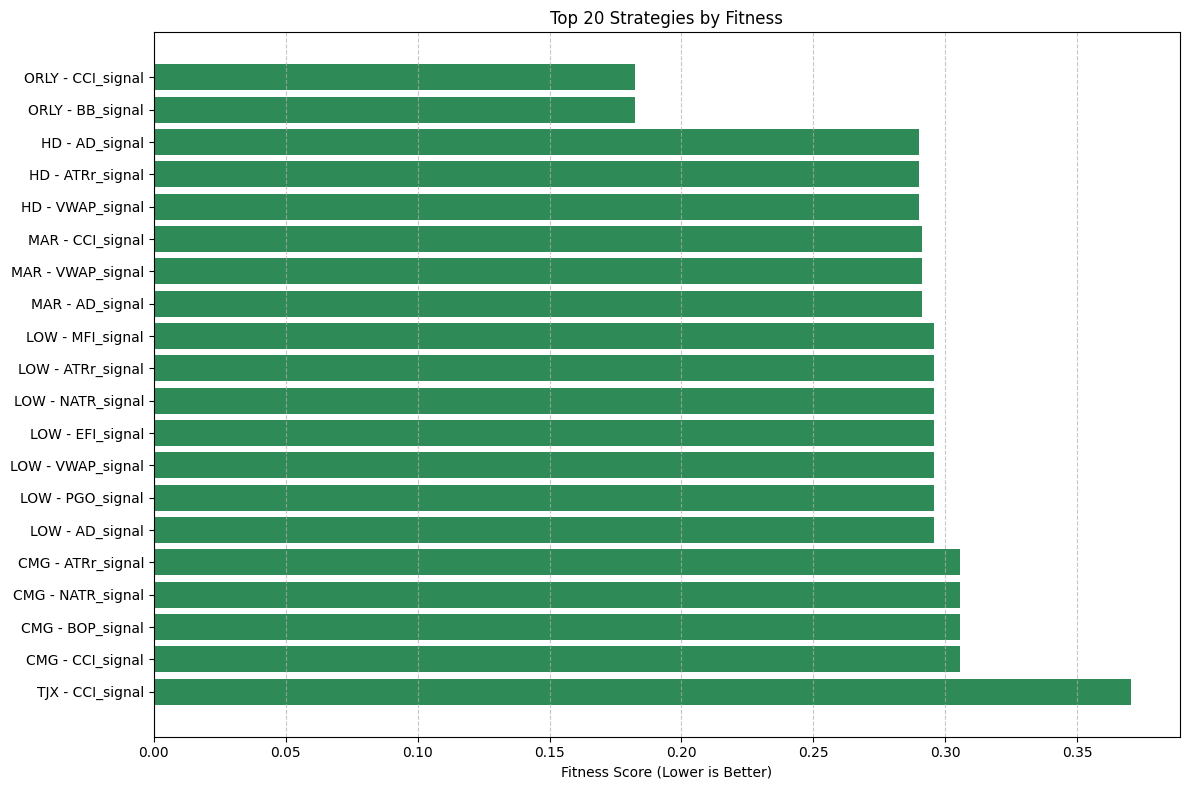

In [ ]:
# # Fitness 기준 상위 20개 선택 (낮을수록 우수한 전략)
# top_fitness = result_df.sort_values(by="Fitness").head(20)

# # 시각화
# plt.figure(figsize=(12, 8))
# bars = plt.barh(
#     y=[f"{row['Ticker']} - {row['Signal']}" for _, row in top_fitness.iterrows()],
#     width=top_fitness["Fitness"],
#     color='seagreen'
# )
# plt.xlabel("Fitness Score (Lower is Better)")
# plt.title("Top 20 Strategies by Fitness")
# plt.gca().invert_yaxis()  # 높은 순위를 위에 표시
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()